# Predict growth rate with macromolecular crowding constraints

In [34]:
from cobra.io import load_json_model

model = load_json_model('data/iJO1366.json')
model.reactions.EX_o2_e.lower_bound = -20
model.optimize()

<Solution 0.98 at 0x7ff24080b1d0>

## Benchmark growth rate predictions without crowding

In [2]:
import pandas as pd

df_meas = pd.read_csv('data/growth_meas.csv')
df_meas

,substrate,growth_rate_1_h,order,ex_rxn
0,glucose,0.740,0.0,EX_glc__D_e
1,maltose,0.620,3.0,EX_malt_e
2,mannose,0.560,NaN,EX_man_e
3,fructose,0.550,NaN,EX_fru_e
4,galactose,0.520,2.0,EX_gal_e
5,succinate,0.460,NaN,EX_succ_e
6,malate,0.440,NaN,EX_mal__L_e
7,glycerol,0.420,4.0,EX_glyc_e
8,lactate,0.390,1.0,EX_lac__L_e
9,acetate,0.256,5.0,EX_ac_e


# Simulate growth without crowding

In [36]:
def simulate_media(model, df_meas, growth_id = 'BIOMASS_Ec_iJO1366_core_53p95M', max_uptake=-10, max_ac=-20, max_o2=-20):
    model.reactions.EX_o2_e.lower_bound = max_o2
    rows = []
    for i,row in df_meas.iterrows():
        # Reset uptakes
        for rxn_id in df_meas.ex_rxn:
            rxn = model.reactions.get_by_id(rxn_id)
            rxn.lower_bound = 0
        # Constrain model to this medium
        substrate = row['substrate']
        rid_medium = row['ex_rxn']
        rxn_medium = model.reactions.get_by_id(rid_medium)    
        if substrate=='acetate':
            rxn_medium.lower_bound = max_ac
        else:
            rxn_medium.lower_bound = max_uptake
        # Simulate
        model.optimize(solver='gurobi')
        rxn_growth = model.reactions.get_by_id(growth_id)        
        rows.append({'substrate':substrate, 'Simulated':rxn_growth.x, 'uptake':rxn_medium.x})

    df_sim = pd.DataFrame(rows)
    df_val = pd.merge(df_sim, df_meas, on='substrate')
    df_val.loc[:,'Measured'] = df_val.growth_rate_1_h
    
    return df_val

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

def plot_growth(df_val):
    g = sns.FacetGrid(df_val, size=5, aspect=1)
    g.map(plt.plot, 'Measured','Simulated', linestyle='None', marker='o', zorder=3, markersize=9, markeredgecolor='black', alpha=0.75)
    mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
    n_subs = len(df_val.substrate.unique())        
    for ax in g.axes.flat:
        ax.plot([0,mumax],[0,mumax], color='#333333')
        for k,(i,row) in enumerate(df_val.sort_values('Simulated').iterrows()):
            substrate = row['substrate']
            x = row['Measured']
            y = row['Simulated']
            xx = mumax
            #xx = x+mumax*0.1
            yy = (k)*mumax/n_subs
            ax.plot([x,xx], [y,yy], color='#000000', alpha=0.5)
            ax.text(xx, yy, substrate, ha='left', va='center')
    ### Performance
    r,p = stats.pearsonr(df_val.Measured, df_val.Simulated)
    rho,prho = stats.spearmanr(df_val.Measured, df_val.Simulated)
    
    ax.set_title("r=%.3g (p=%.2g)\nrho=%.3g (p=%.2g)" %(r,p,rho,prho))
    
    return g

In [38]:
df_val = simulate_media(model, df_meas)

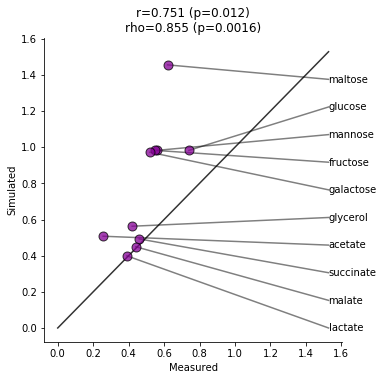

In [39]:
plot_growth(df_val)

# Add molecular crowding

In [40]:
from cobra import Metabolite, Reaction

class Constraint(Metabolite):
    pass

class Variable(Reaction):
    pass

C = 0.34 # g/mL
#a0 = 0.004  # h*gDW/mmol
#a0 = 0.0031  # h*gDW/mmol
a0 = 0.01

## Add crowding constraint
$$
\sum_{i\in \mathrm{Cytosol}} a_i v_i \leq 1
$$

In [41]:
import numpy as np

fbawmc = load_json_model('data/iJO1366.json')

### Crowding constraint:
cons_crowding = Constraint('crowding')
cons_crowding._constraint_sense = 'L'
cons_crowding._bound = 1

model.add_metabolites([cons_crowding])

### Find cytosolic reactions
for rxn in fbawmc.reactions:
    compts = np.array([met.compartment for met in rxn.metabolites.keys()])
    if all(compts=='c'):
        ### Split into forward/reverse if reversible
        if rxn.lower_bound < 0:
            rxn_abs = Reaction(rxn.id + '_abs')
            fbawmc.add_reaction(rxn_abs)
            # rabs >= r  :  rabs - r >= 0
            # rabs >= -r :  rabs + r >= 0        
            cons_abs_p = Constraint('cons_'+rxn.id+'_abs_p')
            cons_abs_n = Constraint('cons_'+rxn.id+'_abs_n')
            cons_abs_p._constraint_sense = 'G'
            cons_abs_n._constraint_sense = 'G'
            rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
            rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})        
            rxn_abs.add_metabolites({cons_crowding:a0})
        else:
            rxn.add_metabolites({cons_crowding: a0})

In [42]:
df_fbawmc = simulate_media(fbawmc, df_meas)

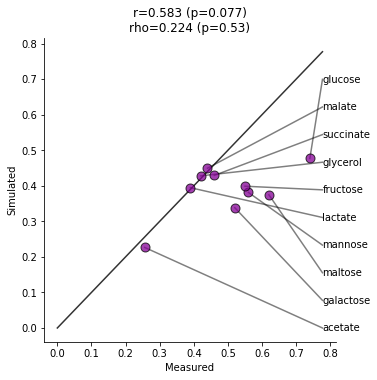

In [43]:
plot_growth(df_fbawmc)

# Do proteome constraints actively limit uptake?

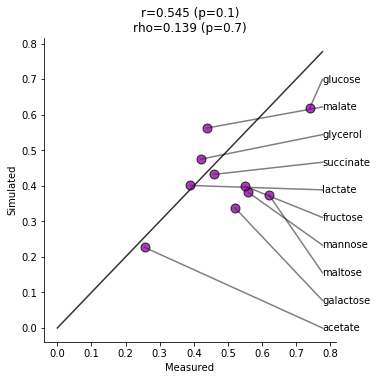

In [45]:
df_uncons = simulate_media(fbawmc, df_meas, max_uptake=-1000, max_ac=-1000)
plot_growth(df_uncons)

In [46]:
df_uncons

,Simulated,substrate,uptake,growth_rate_1_h,order,ex_rxn,Measured
0,0.619034,glucose,-32.502989,0.740,0.0,EX_glc__D_e,0.740
1,0.374560,maltose,-2.042767,0.620,3.0,EX_malt_e,0.620
2,0.381189,mannose,-4.090699,0.560,NaN,EX_man_e,0.560
3,0.398721,fructose,-4.272458,0.550,NaN,EX_fru_e,0.550
4,0.338336,galactose,-3.745574,0.520,2.0,EX_gal_e,0.520
5,0.432149,succinate,-13.127047,0.460,NaN,EX_succ_e,0.460
6,0.562566,malate,-32.401654,0.440,NaN,EX_mal__L_e,0.440
7,0.474677,glycerol,-21.295706,0.420,4.0,EX_glyc_e,0.420
8,0.400837,lactate,-20.947655,0.390,1.0,EX_lac__L_e,0.390
9,0.226576,acetate,-9.311380,0.256,5.0,EX_ac_e,0.256


## Sensitivity to coefficients

In [52]:
%%time

N_RAND = 100

import numpy as np

nCrowd = len(fbawmc.metabolites.crowding.reactions)
crowding = fbawmc.metabolites.crowding
dfs = []
for _iter in range(N_RAND):
    for rxn in crowding.reactions:
        rxn._metabolites[crowding] = a0/3*np.random.gamma(3)

    dfi = simulate_media(fbawmc, df_meas, max_uptake=-1000, max_ac=-1000)
    dfi.loc[:,'k'] = _iter
    dfs.append(dfi)
    
df_rand = pd.concat(dfs)

CPU times: user 1min 45s, sys: 135 ms, total: 1min 45s
Wall time: 1min 45s


In [53]:
def plot_ensemble(df_val):
    df_mean = df_val.groupby('substrate')[['Measured','Simulated']].mean().reset_index()
    cmap = 'nipy_spectral'
    g = sns.FacetGrid(df_val, size=5, aspect=1, hue='substrate')
    g.map(plt.plot, 'Measured','Simulated', linestyle='None', marker='.', zorder=3, markersize=6, alpha=0.9) #, markeredgecolor='black')    
    mumax = max(df_val.Measured.max(), df_val.Simulated.max())*1.05
    nSubs = len(df_val.substrate.unique())
    sns.set_palette(cmap, nSubs)
    plt.plot([0,mumax],[0,mumax], color='#333333')    
    n_subs = len(df_val.substrate.unique())        
    
    #pts = plt.scatter('Measured','Simulated', linestyle='None', marker='o', zorder=4, s=64, alpha=0.9, edgecolor='black', data = df_mean, cmap=cmap)
    for ax in g.axes.flat:
        pts = ax.scatter('Measured','Simulated', linestyle='None', marker='o', zorder=4, s=64, alpha=0.9, edgecolor='black', data = df_mean, facecolor='None')
                
        for k,(i,row) in enumerate(df_mean.sort_values('Simulated').iterrows()):
            substrate = row['substrate']
            x = row['Measured']
            y = row['Simulated']
            xx = mumax
            #xx = x+mumax*0.1
            yy = (k)*mumax/n_subs
            ax.plot([x,xx], [y,yy], color='#333333', alpha=0.5, zorder=1)
            ax.text(xx, yy, substrate, ha='left', va='center')

    ### Performance
    r,p = stats.pearsonr(df_val.Measured, df_val.Simulated)
    rho,prho = stats.spearmanr(df_val.Measured, df_val.Simulated)

    ax.set_title("r=%.3g (p=%.2g)\nrho=%.3g (p=%.2g)" %(r,p,rho,prho))    
    return g

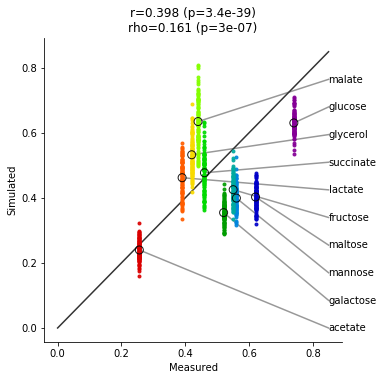

In [54]:
plot_ensemble(df_rand)